<a href="https://colab.research.google.com/github/td-yoshimura/hivemall-notebooks/blob/master/notebooks/news20/randomforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary
By this notebook, you can upload 20news datasets into your Treasure Data account briefly.  
All you have to do is to specify some parameters below and to create the database beforehand.

In [0]:
%env TD_API_KEY = YOUR_TD_API_KEY
%env DATABASE = YOUR_DATABASE_NAME

In addition, this notebook shows how to run a machine learning task with 20news dataset.

# SetUp

<font color="red"><b>You will be asked to input UserName and Password of Treasure Data. Please fill them.</b></font>

In [0]:
!curl -L https://toolbelt.treasuredata.com/sh/install-ubuntu-trusty-td-agent2.sh | sh
!pip install pandas-td
!mkdir trees
!td account -f

# Data Preparation

## Fetch data
It's done by using scikit-learn.

In [0]:
import os
td_api_key = os.environ['TD_API_KEY']
database = os.environ['DATABASE']
table = 'news20'

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
import seaborn as sns

import pandas_td as td
con = td.connect(apikey=td_api_key)

In [0]:
data = fetch_20newsgroups(subset='all')
targets = [data['target_names'][idx] for idx in data['target']]
df = pd.DataFrame({'target':targets, 'text':data['data']})
df['article_id'] = df.index

## Create a table on Treasure Data

In [0]:
td.to_td(df, '{}.{}'.format(database, table), con, if_exists='replace', index=False)

# EDA (Explore data analysis)
Before running machine learning tasks, you should understand your data correctly.  
Descriptive statistics and visualization are important for this.

In [0]:
%matplotlib inline
%load_ext pandas_td.ipython
%td_use $database

import pandas as pd
import matplotlib.pyplot as plt

presto = td.create_engine('presto:{}'.format(database), con=con)
hive = td.create_engine('hive:{}'.format(database), con=con)

## Data Sample

In [0]:
%%td_presto
select
  *
from
    news20
limit 5

,article_id,text,target
time,,,
2018-12-26 06:06:21,10000,From: bhaskar@orion.me.uiuc.edu (Bhaskar Manda...,rec.autos
2018-12-26 06:06:21,10001,From: Eric.Choi@p5.f175.n2240.z1.fidonet.org (...,comp.sys.mac.hardware
2018-12-26 06:06:21,10002,From: henry@zoo.toronto.edu (Henry Spencer)\nS...,sci.electronics
2018-12-26 06:06:21,10003,From: whitsebd@nextwork.rose-hulman.edu (Bryan...,soc.religion.christian
2018-12-26 06:06:21,10004,From: mjones@watson.ibm.com (Mike Jones)\nSubj...,rec.sport.baseball


## Data size

In [0]:
%%td_presto
select 
  count(*) as n_article
  ,count(distinct target) as n_class 
from 
  news20

,n_article,n_class
0,18846,20


## Target

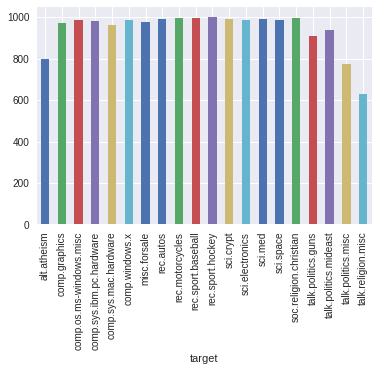

In [0]:
td.read_td_query('''
  select
    target
    ,count(*) as n
  from
    news20
  group by
    1
  order by
    target
'''.format(table=table), engine=presto, index_col='target')['n'].plot.bar()

## The number of word for each article

### Preprocess
`tokenize` function splits a text into words.  
https://hivemall.incubator.apache.org/userguide/misc/tokenizer.html

In [0]:
%%td_hive
select
  target
  ,text
  ,tokenize(text, true) as tokenized
  ,size(tokenize(text, true)) as n_word
from
  news20
limit 5

,target,text,tokenized,n_word
0,rec.autos,From: bhaskar@orion.me.uiuc.edu (Bhaskar Manda...,"[from, bhaskar@orion, me, uiuc, edu, bhaskar, ...",260
1,comp.sys.mac.hardware,From: Eric.Choi@p5.f175.n2240.z1.fidonet.org (...,"[from, eric, choi@p5, f175, n2240, z1, fidonet...",93
2,sci.electronics,From: henry@zoo.toronto.edu (Henry Spencer)\nS...,"[from, henry@zoo, toronto, edu, henry, spencer...",178
3,soc.religion.christian,From: whitsebd@nextwork.rose-hulman.edu (Bryan...,"[from, whitsebd@nextwork, rose-hulman, edu, br...",95
4,rec.sport.baseball,From: mjones@watson.ibm.com (Mike Jones)\nSubj...,"[from, mjones@watson, ibm, com, mike, jones, s...",640


### View data

In [0]:
td.read_td_query('''
  select
    size(tokenize(text, true)) as n_word
  from
    news20
''', engine=hive).describe()

,n_word
count,18846.000000
mean,310.510665
std,690.912549
min,15.000000
25%,117.000000
50%,187.000000
75%,307.000000
max,31621.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d3fe2f6a0>]],
      dtype=object)

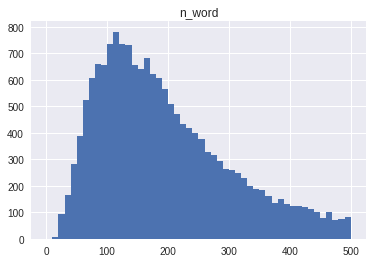

In [0]:
td.read_td_query('''
  select
    size(tokenize(text, true)) as n_word
  from
    news20
''', engine=hive).hist(range=(0,500), bins=50)

In [0]:
data = td.read_td_query('''
  select
    target
    ,avg(size(tokenize(text, true))) as average
    ,variance(size(tokenize(text, true))) as variance
  from
    news20
  group by
    1
  order by
    1
''', engine=hive, index_col='target')

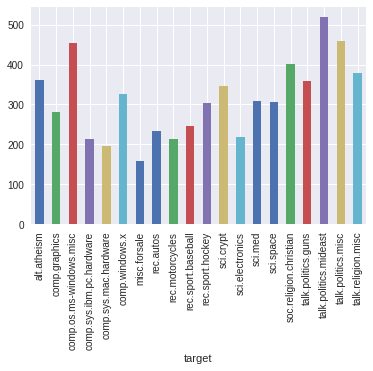

In [0]:
data['average'].plot.bar()

# Run machine learning task

## Tokenize text

In [0]:
!td table:delete $DATABASE news20_text_parsed
!td table:create $DATABASE news20_text_parsed

This query will take a long time (about 20 min)

In [0]:
%%td_hive
insert overwrite table news20_text_parsed
select
  article_id
  ,target
  ,text
  ,word
  ,count(*) as n
from
  news20  
lateral view
  explode(tokenize(text, true)) t as word
group by
  1,2,3,4

The table created is below.

In [0]:
%%td_presto
select
  *
from
  news20_preprocessed
limit 5

,article_id,target,text,word,n
time,,,,,
2018-12-26 07:53:09,18321,comp.os.ms-windows.misc,From: mitchell@nodecg.ncc.telecomwa.oz.au (Cli...,v-,2
2018-12-26 07:53:09,18321,comp.os.ms-windows.misc,From: mitchell@nodecg.ncc.telecomwa.oz.au (Cli...,v-/8,1
2018-12-26 07:53:09,18321,comp.os.ms-windows.misc,From: mitchell@nodecg.ncc.telecomwa.oz.au (Cli...,v/,1
2018-12-26 07:53:09,18321,comp.os.ms-windows.misc,From: mitchell@nodecg.ncc.telecomwa.oz.au (Cli...,v/i,1
2018-12-26 07:53:09,18321,comp.os.ms-windows.misc,From: mitchell@nodecg.ncc.telecomwa.oz.au (Cli...,v0,1


## Add weight with td-idf
You can use `n` as weight of each word, but there is a better way.  
TD-IDF is a value representing the importance of word in each texts.  
[Wikipedia of tf-idf in English](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)  
[Wikipedia of tf-idf in Japanese](https://ja.wikipedia.org/wiki/Tf-idf)


In [0]:
!td table:delete -f $DATABASE news20_tfidf_added
!td table:create $DATABASE news20_tfidf_added

This query will take a long time (about 20 min)

In [0]:
%%td_presto
insert into news20_tfidf_added 
with tf as (
  select
    article_id
    ,word
    ,cast(count(*) as double) / sum(count(*)) over(partition by article_id) as tf
  from
    news20_text_parsed
  group by
    1,2
)

,df as (
  select
    word
    ,cast(count(distinct article_id) as double) / (select count(distinct article_id) from news20_text_parsed) as df
  from
    news20_text_parsed
  group by
    1
)

select
  t.article_id
  ,t.target
  ,t.text
  ,replace(t.word, ':|#', '') as word -- remove ":" and "#"
  ,t.n
  ,tf.tf * ln(power(df.df, -1)) as tfidf
from
  news20_text_parsed t
  inner join
  tf
  on
    t.article_id = tf.article_id
    and
    t.word = tf.word
  inner join
  df
  on
    t.word = df.word;

,rows
0,3094185


The table created is below.

In [0]:
%%td_presto
select
  *
from
  news20_tfidf_added
order by
  tfidf desc
limit 5

,article_id,target,text,word,n,tfidf
time,,,,,,
2018-12-26 09:00:49,16653,alt.atheism,From: Edwin Gans\nSubject: Atheism\nNntp-Posti...,gans,1,0.656270
2018-12-26 09:00:49,6426,comp.windows.x,From: skji@eve.kaist.ac.KR (Ji SoonKi)\nSubjec...,skji@eve,2,0.615253
2018-12-26 09:00:49,6426,comp.windows.x,From: skji@eve.kaist.ac.KR (Ji SoonKi)\nSubjec...,soonki,1,0.615253
2018-12-26 09:00:49,10877,comp.graphics,From: hl7204@eehp22 (H L)\nSubject: Re: Graphi...,hl7204@eehp22,1,0.579062
2018-12-26 09:00:49,14924,comp.windows.x,From: gtkurdy@access.digex.net (GodTom)\nSubje...,tommyvision,1,0.579062


## Aggregate data and split into training data and test data
The data is splitted into training data and test data.  
Articles whose article_id's ones place in 7 or 8 or 9 are assigned to test data,  
others are assigned to training data.  
Machine learning model is created by training data, and it's evaluated by test data.

Also, data is aggregated so as to 1 record / 1 article.

In [0]:
!td table:delete -f $DATABASE news20_aggregate
!td table:create $DATABASE news20_aggregate

In [0]:
%%td_hive
insert overwrite table news20_aggregate
select
  article_id
  ,target
  ,case when article_id % 10 in (7,8,9) then 'test' else 'train' end as class
  ,collect_set(feature(word, tfidf)) as word_with_weight
  ,sum(n) as n_word
from
  news20_tfidf_added
group by
  1,2

The table created is below.

In [0]:
%%td_presto
select
  *
from
  news20_aggregate
limit 5

,article_id,target,class,word_with_weight,n_word
time,,,,,
2018-12-26 09:28:00,14,alt.atheism,train,"[bucaille:0.10293272570415753, learning:0.0620...",111
2018-12-26 09:28:00,19,rec.motorcycles,test,"[lies:0.02242048701027554, anglia:0.0345954438...",360
2018-12-26 09:28:00,33,rec.sport.baseball,train,"[going:0.022690651426093777, was:0.00930888342...",136
2018-12-26 09:28:00,43,rec.autos,train,"[the:0.0010707027994893944, a:0.00207977309413...",88
2018-12-26 09:28:00,49,comp.os.ms-windows.misc,test,"[want:0.026274898057078548, wl-1:0.11436969522...",107


## Convert data into Hivemall input format

In [0]:
!td table:delete -f $DATABASE news20_train_data
!td table:create $DATABASE news20_train_data

In [0]:
%%td_hive
insert overwrite table news20_train_data
select
  article_id
  ,target
  ,(dense_rank() over(order by target)) - 1 as target_id
  ,class
  ,word_with_weight
  ,n_word
  ,array_concat(feature_hashing(word_with_weight, '-features 1000'), array(feature(1001, n_word))) as sparse_features 
  ,to_dense_features(array_concat(feature_hashing(word_with_weight, '-features 1000'), array(feature(1001, n_word))), 1001) as dense_features 
from
  news20_aggregate

The table created is below.

In [0]:
%%td_presto
select
  *
from
  news20_train_data
limit 5

,article_id,target,target_id,class,word_with_weight,n_word,sparse_features,dense_features
time,,,,,,,,
2018-12-26 10:01:50,9603,alt.atheism,0,train,"[wrote:0.020293138749969377, united:0.03071855...",198,"[39:0.020293138749969377, 718:0.03071855585543...","[None, None, None, None, None, None, None, Non..."
2018-12-26 10:01:50,9645,alt.atheism,0,train,"[anecdote:0.03834577992242249, on:0.0030592858...",285,"[679:0.03834577992242249, 878:0.00305928589836...","[None, None, None, 0.01308276318013668, None, ..."
2018-12-26 10:01:50,9729,alt.atheism,0,test,"[essential:0.036825232130209745, suffering:0.0...",207,"[31:0.036825232130209745, 398:0.03411780820084...","[None, None, None, None, None, None, None, Non..."
2018-12-26 10:01:50,10023,alt.atheism,0,train,"[case:0.01084380680464114, car:0.0143130763683...",577,"[850:0.01084380680464114, 850:0.01431307636836...","[None, None, None, None, None, None, None, Non..."
2018-12-26 10:01:50,10030,alt.atheism,0,train,"[and:0.001997482549206443, 1:0.014105130536907...",112,"[528:0.001997482549206443, 687:0.0141051305369...","[None, None, None, None, None, None, None, Non..."


## Build a model with Random Forest Classifier
[wikipdia of RandomForest in English](https://en.wikipedia.org/wiki/Random_forest)  
[wikipdia of RandomForest in Japanese](https://ja.wikipedia.org/wiki/%E3%83%A9%E3%83%B3%E3%83%80%E3%83%A0%E3%83%95%E3%82%A9%E3%83%AC%E3%82%B9%E3%83%88)

In [0]:
!td table:delete -f $DATABASE news20_randomforest_model
!td table:create $DATABASE news20_randomforest_model

In [0]:
%%td_hive
insert overwrite table news20_randomforest_model
select
  train_randomforest_classifier(dense_features, target_id, '-trees 50')
  -- train_randomforest_classifier(dense_features, target_id, '-trees 50 -splits 10 -leafs 1 -depth 1000')
from
  news20_train_data
where
  class = 'train'

The table created is below.

In [0]:
%%td_presto
select
  *
from
  news20_randomforest_model
limit 5

,model_id,model_weight,model,var_importance,oob_errors,oob_tests
time,,,,,,
2018-12-27 03:27:56,3c72729e-39b6-4c41-9c99-d3b641accea3,0.192395,I?brQF6a3iZW;%gYKOAGKz_A)HR5)O0/2H-JzNtPa6K{N(...,"[0.0, 1.248896028873176, 0.4887595271265346, 4...",0,0
2018-12-27 03:27:56,fa3f538f-eba4-4689-93c7-0c36238709dd,0.185353,"I?brQF<ZO5gr>%p,g*v{$:^)HHF~(/fx!G.tQ7aD_XIUXQ...","[0.0, 0.1763085399449037, 2.05214300902384, 4....",0,0
2018-12-27 03:27:56,7823f57e-dd61-4b47-b817-931b11251ef1,0.172129,I?brQF_Z4>pW^%=W+O|W!iF8uO=4}t]_lYAD(.`BFEXh|_...,"[0.0, 1.5532025990050413, 1.1958397509513885, ...",0,0
2018-12-27 03:27:56,3a2de7e9-cc14-4dd1-b527-251dece3e2d1,0.176458,I?brQF<ZO5gr>%NH~Cuc&q7Wp4)B%W#f)FPcO~:t|FZag?...,"[0.0, 0.8163140869917167, 0.9540537783864685, ...",0,0
2018-12-27 03:27:56,a564e3d8-9ab7-41a6-9356-cfa6ca65be9c,0.180277,I?brQF<ZO5gr>%*BBW8FAD!0PHu1b>>cnMYYaYHOwYnB;I...,"[0.0, 0.6429974603067193, 1.8194567738607963, ...",0,0


## Predict

In [0]:
!td table:delete -f $DATABASE news20_randomforest_predicted
!td table:create $DATABASE news20_randomforest_predicted

In [0]:
%%td_hive
insert overwrite table news20_randomforest_predicted
SELECT
  article_id,
  class,
  target_id,
  rf_ensemble(predicted.value, predicted.posteriori, model_weight).label as predicted
FROM (
  SELECT
    t.article_id,
    class,
    target_id,
    p.model_weight,
    tree_predict(p.model_id, p.model, t.dense_features, "-classification") as predicted
  FROM (
    SELECT 
      model_id, model_weight, model
    FROM news20_randomforest_model
    DISTRIBUTE BY rand(1)
  ) p
  LEFT OUTER JOIN news20_train_data t
) t1
group by
  1,2,3

In [0]:
%%td_presto
select
  *
from
  news20_randomforest_predicted
limit 5

,article_id,class,target_id,predicted
time,,,,
2018-12-27 03:33:27,0,train,10,10
2018-12-27 03:33:27,1,train,3,3
2018-12-27 03:33:27,2,train,17,17
2018-12-27 03:33:27,3,train,3,3
2018-12-27 03:33:27,4,train,4,4


## Evaluate

### Train

Accuracy : 99.95% (= 13,187.0 / 13,194.0)


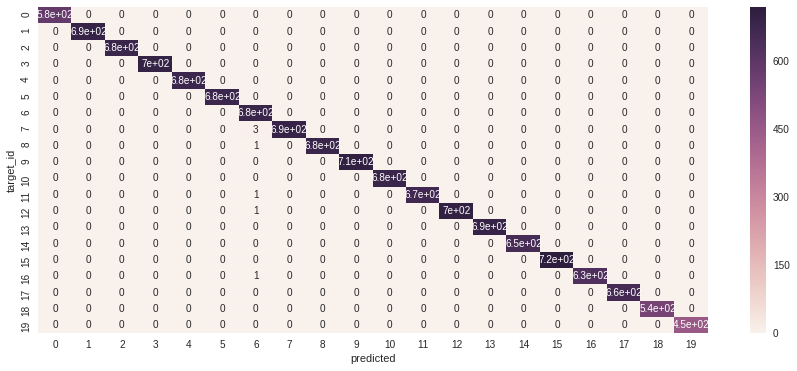

In [0]:
result = td.read_td_query('''
  select
    class
    ,target_id
    ,predicted
    ,count(*) as n
  from
    news20_randomforest_predicted
  where
    class = 'train'
  group by
    1,2,3
''', engine=presto).pivot(index='target_id', columns='predicted', values='n').fillna(0)

# Calculate the accuracy
n_correct = np.trace(result)
n_total = result.sum().sum()
print('Accuracy : {:.2%} (= {:,} / {:,})'.format(n_correct / n_total, n_correct, n_total))

# Picture
fig, ax = plt.subplots(figsize=(15,6))
sns.heatmap(result, annot=True, ax=ax)
plt.show()

### Test

Accuracy : 51.34% (= 2,902.0 / 5,652.0)


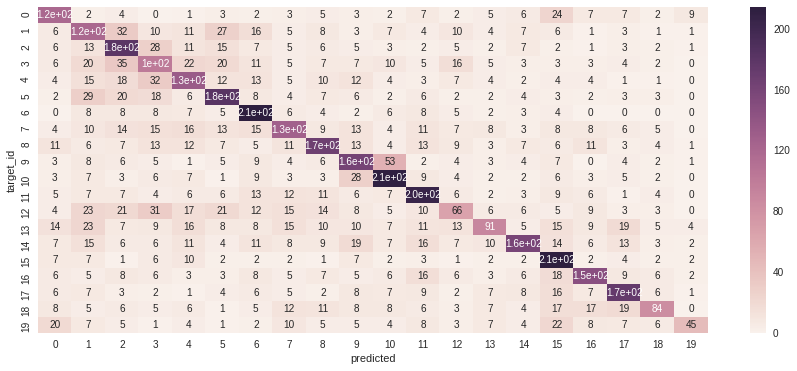

In [0]:
result = td.read_td_query('''
  select
    class
    ,target_id
    ,predicted
    ,count(*) as n
  from
    news20_randomforest_predicted
  where
    class = 'test'
  group by
    1,2,3
''', engine=presto).pivot(index='target_id', columns='predicted', values='n').fillna(0)

# Calculate the accuracy
n_correct = np.trace(result)
n_total = result.sum().sum()
print('Accuracy : {:.2%} (= {:,} / {:,})'.format(n_correct / n_total, n_correct, n_total))

# Picture
fig, ax = plt.subplots(figsize=(15,6))
sns.heatmap(result, annot=True, ax=ax)
plt.show()

## Check the variable importance
The bigger the value is, the better it is.

In [0]:
%%td_hive
select
  n as index
  ,subarray(importances, n-1, n)[0] as importance
from (
  select
    array_sum(var_importance) as importances
  from 
    news20_randomforest_model
  ) t
lateral view
  generate_series(1,1001) t as n
limit 5

,index,importance
0,1,0.000000
1,2,41.855683
2,3,79.576376
3,4,191.021420
4,5,34.466099
